In [1]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

# make sure our main code dir is on the path, change this:
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0, codepath)

from feature_extraction import texture_statistics_pyramid

This code is meant to be used for comparing our feature extraction method with the original Matlab code. To run it, download the following repositories:

https://github.com/freeman-lab/metamers

https://github.com/LabForComputationalVision/matlabPyrTools

#### Set up a GPU if available (otherwise proceed with cpu)

In [2]:
import torch

if torch.cuda.is_available():
    # device = torch.device('cpu:0')
    print ('#device:', torch.cuda.device_count())
    print ('device#:', torch.cuda.current_device())
    print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

    torch.manual_seed(time.time())
    device = torch.device("cuda:0") #cuda
    torch.backends.cudnn.enabled=True

    print ('\ntorch:', torch.__version__)
    print ('cuda: ', torch.version.cuda)
    print ('cudnn:', torch.backends.cudnn.version())
    print ('dtype:', torch.get_default_dtype())
    #torch.set_default_dtype(torch.float64)
else:
    device = 'cpu:0'

#### Load a test image

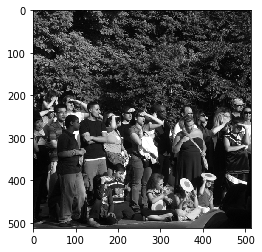

In [3]:
image = Image.open('example-im-512x512.png')
image = np.reshape(image.getdata(),[512,512])

plt.figure();
plt.pcolormesh(image, cmap='gray')
plt.axis('square')
plt.gca().invert_yaxis()

#### Create pyramid feature extractor 
Utilizes code in 'feature_extraction/texture_statistics_pyramid' and 'utils/texture_utils'

In [4]:
n_ori=4;
n_sf=4;

# making a duplicate of this image, to prevent a singleton dimension
images = np.tile(np.expand_dims(np.expand_dims(image, axis=0), axis=0), [2,1,1,1])

_fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height=n_sf, n_ori = n_ori)

print('Running steerable pyramid feature extraction...')
print('Images array shape is:')
print(images.shape)
t = time.time()
fmaps = _fmaps_fn(images, to_torch=False, device=device)        
elapsed =  time.time() - t
print('time elapsed = %.5f'%elapsed)

Running steerable pyramid feature extraction...
Images array shape is:
(2, 1, 512, 512)
time elapsed = 2.41382


#### Extract all the texture features (for one example pRF)

In [5]:

# DON'T CHANGE these prf parameters, because i've manually entered values for this prf into the matlab test script.
prf_params = [0,0,0.5]

pixel_stats, mean_magnitudes, mean_realparts, marginal_stats_lowpass_recons, variance_highpass_resid, \
            magnitude_feature_autocorrs, lowpass_recon_autocorrs, highpass_resid_autocorrs, \
            magnitude_within_scale_crosscorrs, real_within_scale_crosscorrs, magnitude_across_scale_crosscorrs, real_imag_across_scale_crosscorrs, \
            real_spatshift_within_scale_crosscorrs, real_spatshift_across_scale_crosscorrs =   \
    texture_statistics_pyramid.get_all_features(fmaps, images, prf_params, sample_batch_size=20, n_prf_sd_out=2, aperture=1.0, \
                                                         device=device, keep_orig_shape=True)


    

#### Comparing some of the numerical values here, to the values generated in original matlab code.
The scales go in opposite order here: in my pipeline they go low SF (small size image) to high SF (bigger images). In matlab code they go high to low. 

Accounting for that here: if I put ff=3 here, then that corresponds to sc=1 in matlab code (for pyramid height=4)

In [6]:
npix_each_scale = [_fmaps_fn.pyr.pyr_size[(sc,0)][0] for sc in range(n_sf)]
npix_each_scale.append(_fmaps_fn.pyr.pyr_size['residual_lowpass'][0])
    
print('pixel features in original image')
names = ['mean', 'var', 'skew', 'kurt', 'min', 'max'];
for pp in range(6):
    print('  Weighted %s in original image: %.8f'%(names[pp],pixel_stats[0,pp]))
    
print('Mean of feature magnitudes in each band [nSF x nOri]\n')
print(torch.flipud(mean_magnitudes[0,:,:]))
    
ori1 = 0
ori2 = 1

# ff=0
# ff_reverse = n_sf-1 - ff
print('lowpass band, npix=%d'%npix_each_scale[n_sf])
print('   Weighted skew: %.8f'%marginal_stats_lowpass_recons[0,0,0])        
print('   Weighted kurtosis: %.8f'%marginal_stats_lowpass_recons[0,0,1])        

print('   Lowpass recon autocorrelation: %.8f'%lowpass_recon_autocorrs[0,0,0]) # low-freq residual is the first element here
print('   Real/spatially shifted lowpass within scale cross-correlation: %.8f'%real_spatshift_within_scale_crosscorrs[0,0,0,1])

for ff in range(4):
    

    ff_reverse = n_sf-1 - ff
#     print([ff, ff_reverse])
    print('sc=%d, npix=%d'%(ff,npix_each_scale[ff_reverse]))
    print('   Weighted skew: %.8f'%marginal_stats_lowpass_recons[0,ff+1,0])        
    print('   Weighted kurtosis: %.8f'%marginal_stats_lowpass_recons[0,ff+1,1]) # low-freq residual is the first element here


    print('   Magnitude autocorrelation: %.8f'%magnitude_feature_autocorrs[0,ff,0,0])
    print('   Lowpass recon autocorrelation: %.8f'%lowpass_recon_autocorrs[0,ff+1,0]) # low-freq residual is the first element here

    print('   Magnitude within scale cross-correlation: %.8f'%magnitude_within_scale_crosscorrs[0,ff,0])
    print('   Real within scale cross-correlation: %.8f'%real_within_scale_crosscorrs[0,ff,0])

    
    if ff>0:
        print('   Magnitude across scale cross-correlation: %.8f'%magnitude_across_scale_crosscorrs[0,ff-1,ori1, ori2])

        print('   Real/real across scale cross-correlation: %.8f'%real_imag_across_scale_crosscorrs[0,ff-1,0,ori1, ori2])
        print('   Real/imag across scale cross-correlation: %.8f'%real_imag_across_scale_crosscorrs[0,ff-1,1,ori1, ori2])
    else:
        print('   Real/spatially shifted lowpass across scale cross-correlation: %.8f'%real_spatshift_across_scale_crosscorrs[0,ff,ori1,1])

ff=3
ff_reverse = n_sf-1 - ff
print('highpass residual, npix=%d'%npix_each_scale[ff_reverse])      
print('   Highpass residual autocorrelation: %.8f'%highpass_resid_autocorrs[0,0,0])
print('   Highpass residual variance: %.8f'%variance_highpass_resid[0,0])

pixel features in original image
  Weighted mean in original image: 62.50595856
  Weighted var in original image: 3357.05419922
  Weighted skew in original image: 1.37655067
  Weighted kurt in original image: 4.34468365
  Weighted min in original image: 0.00000000
  Weighted max in original image: 255.00000000
Mean of feature magnitudes in each band [nSF x nOri]

tensor([[  7.8362,   6.9335,   7.8864,   8.3251],
        [ 40.2791,  35.0464,  40.9765,  41.8074],
        [199.5609, 172.5812, 211.9737, 213.4395],
        [949.7429, 797.1474, 872.5569, 911.1714]])
lowpass band, npix=32
   Weighted skew: 1.23761809
   Weighted kurtosis: 5.61488008
   Lowpass recon autocorrelation: 74469224.00000000
   Real/spatially shifted lowpass within scale cross-correlation: 1371.39807129
sc=0, npix=64
   Weighted skew: 1.25712848
   Weighted kurtosis: 4.82801771
   Magnitude autocorrelation: 521725.40625000
   Lowpass recon autocorrelation: 6981264.00000000
   Magnitude within scale cross-correlation: